# Speech to Emotion Recognition (SER)

In [1]:
import librosa
from librosa import display
import os

In [2]:
import time
import os
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path

def prepare_RAVDESS_DS(path_audios='./dataset'):
    """
    Generation of the dataframe with the information of the dataset. The dataframe has the following structure:
     ______________________________________________________________________________________________________________________________
    |             name            |                     path                                   |     emotion      |     actor     |
    ______________________________________________________________________________________________________________________________
    |  01-01-01-01-01-01-01.wav   |    <RAVDESS_dir>/audios_16kHz/01-01-01-01-01-01-01.wav     |     Neutral      |     1         |
    ______________________________________________________________________________________________________________________________
    ...
    :param path_audios: Path to the folder that contains all the audios in .wav format, 16kHz and single-channel(mono)
    """
    data = []
    for path in tqdm(Path(path_audios).glob("**/*.wav")):
        name = str(path).split('/')[-1].split('.')[0]
        label = int(name.split("-")[2]) - 1  # Start emotions in 0

        try:
            X, sr = librosa.load(path, res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
            
            arr = mfccs, label
            data.append(arr)
            
        except Exception as e:
            # print(str(path), e)
            pass
    
    return data



lst = prepare_RAVDESS_DS()

0it [00:00, ?it/s]

In [3]:
#This zip() function makes list of all first elements and store in X
#also it stores all the second elements in y

mfcc, emotions = zip(*lst)

In [4]:
len(emotions)

1440

In [5]:
mfcc = np.asarray(mfcc)
emotions = np.asarray(emotions)

In [6]:
from sklearn.model_selection import train_test_split

mfcc_train, mfcc_test, emotions_train, emotions_test = train_test_split(mfcc,emotions, test_size=.2, random_state=2022)

In [7]:
mfcc_train.shape, emotions_train.shape, mfcc_test.shape, emotions_test.shape

((1152, 40), (1152,), (288, 40), (288,))

In [8]:
import numpy as np

mfcc_train = np.expand_dims(mfcc_train, axis=2)
mfcc_test = np.expand_dims(mfcc_test, axis=2)

In [9]:
mfcc_train.shape, emotions_train.shape, mfcc_test.shape, emotions_test.shape

((1152, 40, 1), (1152,), (288, 40, 1), (288,))

## Defining Model for training

##### Used Keras library from tensorflow framework to define a sequencial CNN Model and added layers according to operation be performed on input mfcc features

In [10]:
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv1D(64, 5,padding='same',input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            384       
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0

In [12]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [13]:
cnnhistory=model.fit(mfcc_train, emotions_train, batch_size=16, epochs=500, validation_data=(mfcc_test, emotions_test))

Epoch 1/500
72/72 [==============================] - 3s 8ms/step - loss: 5.0596 - accuracy: 0.1441 - val_loss: 2.2254 - val_accuracy: 0.1458
Epoch 2/500
72/72 [==============================] - 0s 7ms/step - loss: 4.1602 - accuracy: 0.1441 - val_loss: 2.1454 - val_accuracy: 0.1389
Epoch 3/500
72/72 [==============================] - 1s 7ms/step - loss: 3.7548 - accuracy: 0.1406 - val_loss: 2.0353 - val_accuracy: 0.1597
Epoch 4/500
72/72 [==============================] - 0s 7ms/step - loss: 3.1520 - accuracy: 0.1675 - val_loss: 2.0702 - val_accuracy: 0.2049
Epoch 5/500
72/72 [==============================] - 1s 7ms/step - loss: 2.9427 - accuracy: 0.1840 - val_loss: 1.9514 - val_accuracy: 0.2292
Epoch 6/500
72/72 [==============================] - 1s 7ms/step - loss: 2.7156 - accuracy: 0.1693 - val_loss: 2.0690 - val_accuracy: 0.1979
Epoch 7/500
72/72 [==============================] - 1s 8ms/step - loss: 2.5523 - accuracy: 0.1797 - val_loss: 2.0805 - val_accuracy: 0.1910
Epoch 8/500
7

72/72 [==============================] - 1s 9ms/step - loss: 1.3988 - accuracy: 0.5052 - val_loss: 1.4930 - val_accuracy: 0.4618
Epoch 116/500
72/72 [==============================] - 1s 9ms/step - loss: 1.3780 - accuracy: 0.4835 - val_loss: 1.5766 - val_accuracy: 0.4097
Epoch 117/500
72/72 [==============================] - 1s 9ms/step - loss: 1.3805 - accuracy: 0.5026 - val_loss: 1.5136 - val_accuracy: 0.4549
Epoch 118/500
72/72 [==============================] - 1s 9ms/step - loss: 1.3707 - accuracy: 0.4861 - val_loss: 1.5358 - val_accuracy: 0.4375
Epoch 119/500
72/72 [==============================] - 1s 9ms/step - loss: 1.3539 - accuracy: 0.5026 - val_loss: 1.5426 - val_accuracy: 0.3889
Epoch 120/500
72/72 [==============================] - 1s 8ms/step - loss: 1.3575 - accuracy: 0.4974 - val_loss: 1.5172 - val_accuracy: 0.4618
Epoch 121/500
72/72 [==============================] - 1s 8ms/step - loss: 1.3787 - accuracy: 0.4931 - val_loss: 1.4799 - val_accuracy: 0.4653
Epoch 122/500

72/72 [==============================] - 1s 10ms/step - loss: 0.9138 - accuracy: 0.6736 - val_loss: 1.3381 - val_accuracy: 0.5312
Epoch 230/500
72/72 [==============================] - 1s 10ms/step - loss: 0.8886 - accuracy: 0.6780 - val_loss: 1.3697 - val_accuracy: 0.5451
Epoch 231/500
72/72 [==============================] - 1s 10ms/step - loss: 0.8853 - accuracy: 0.6962 - val_loss: 1.3488 - val_accuracy: 0.5312
Epoch 232/500
72/72 [==============================] - 1s 9ms/step - loss: 0.9038 - accuracy: 0.6788 - val_loss: 1.3695 - val_accuracy: 0.5243
Epoch 233/500
72/72 [==============================] - 1s 9ms/step - loss: 0.8707 - accuracy: 0.6901 - val_loss: 1.4082 - val_accuracy: 0.5278
Epoch 234/500
72/72 [==============================] - 1s 10ms/step - loss: 0.8921 - accuracy: 0.6762 - val_loss: 1.3580 - val_accuracy: 0.5486
Epoch 235/500
72/72 [==============================] - 1s 10ms/step - loss: 0.8450 - accuracy: 0.6953 - val_loss: 1.4111 - val_accuracy: 0.5104
Epoch 23

72/72 [==============================] - 1s 10ms/step - loss: 0.7308 - accuracy: 0.7457 - val_loss: 1.3720 - val_accuracy: 0.5382
Epoch 287/500
72/72 [==============================] - 1s 10ms/step - loss: 0.7421 - accuracy: 0.7422 - val_loss: 1.4175 - val_accuracy: 0.5486
Epoch 288/500
72/72 [==============================] - 1s 10ms/step - loss: 0.7332 - accuracy: 0.7413 - val_loss: 1.3519 - val_accuracy: 0.5417
Epoch 289/500
72/72 [==============================] - 1s 10ms/step - loss: 0.7284 - accuracy: 0.7422 - val_loss: 1.3894 - val_accuracy: 0.5625
Epoch 290/500
72/72 [==============================] - 1s 10ms/step - loss: 0.7170 - accuracy: 0.7552 - val_loss: 1.3609 - val_accuracy: 0.5556
Epoch 291/500
72/72 [==============================] - 1s 10ms/step - loss: 0.7076 - accuracy: 0.7587 - val_loss: 1.3801 - val_accuracy: 0.5556
Epoch 292/500
72/72 [==============================] - 1s 10ms/step - loss: 0.7148 - accuracy: 0.7457 - val_loss: 1.3907 - val_accuracy: 0.5451
Epoch 

72/72 [==============================] - 1s 10ms/step - loss: 0.5960 - accuracy: 0.7847 - val_loss: 1.3637 - val_accuracy: 0.5625
Epoch 344/500
72/72 [==============================] - 1s 10ms/step - loss: 0.5634 - accuracy: 0.8073 - val_loss: 1.3823 - val_accuracy: 0.5660
Epoch 345/500
72/72 [==============================] - 1s 10ms/step - loss: 0.5797 - accuracy: 0.8038 - val_loss: 1.3891 - val_accuracy: 0.5382
Epoch 346/500
72/72 [==============================] - 1s 10ms/step - loss: 0.5737 - accuracy: 0.7873 - val_loss: 1.3559 - val_accuracy: 0.5694
Epoch 347/500
72/72 [==============================] - 1s 10ms/step - loss: 0.5867 - accuracy: 0.7925 - val_loss: 1.3571 - val_accuracy: 0.5660
Epoch 348/500
72/72 [==============================] - 1s 10ms/step - loss: 0.5722 - accuracy: 0.7934 - val_loss: 1.4074 - val_accuracy: 0.5521
Epoch 349/500
72/72 [==============================] - 1s 10ms/step - loss: 0.5677 - accuracy: 0.8030 - val_loss: 1.3768 - val_accuracy: 0.5729
Epoch 

72/72 [==============================] - 1s 10ms/step - loss: 0.4821 - accuracy: 0.8394 - val_loss: 1.4111 - val_accuracy: 0.5694
Epoch 401/500
72/72 [==============================] - 1s 10ms/step - loss: 0.4790 - accuracy: 0.8264 - val_loss: 1.4275 - val_accuracy: 0.5764
Epoch 402/500
72/72 [==============================] - 1s 10ms/step - loss: 0.4649 - accuracy: 0.8403 - val_loss: 1.4399 - val_accuracy: 0.5625
Epoch 403/500
72/72 [==============================] - 1s 10ms/step - loss: 0.4750 - accuracy: 0.8290 - val_loss: 1.4356 - val_accuracy: 0.5625
Epoch 404/500
72/72 [==============================] - 1s 10ms/step - loss: 0.4646 - accuracy: 0.8420 - val_loss: 1.4600 - val_accuracy: 0.5694
Epoch 405/500
72/72 [==============================] - 1s 10ms/step - loss: 0.4326 - accuracy: 0.8481 - val_loss: 1.3849 - val_accuracy: 0.5694
Epoch 406/500
72/72 [==============================] - 1s 10ms/step - loss: 0.4398 - accuracy: 0.8524 - val_loss: 1.4398 - val_accuracy: 0.5451
Epoch 

72/72 [==============================] - 1s 9ms/step - loss: 0.3729 - accuracy: 0.8759 - val_loss: 1.4543 - val_accuracy: 0.5903
Epoch 458/500
72/72 [==============================] - 1s 9ms/step - loss: 0.3904 - accuracy: 0.8715 - val_loss: 1.4653 - val_accuracy: 0.6042
Epoch 459/500
72/72 [==============================] - 1s 9ms/step - loss: 0.3854 - accuracy: 0.8785 - val_loss: 1.4913 - val_accuracy: 0.5590
Epoch 460/500
72/72 [==============================] - 1s 10ms/step - loss: 0.3734 - accuracy: 0.8637 - val_loss: 1.3805 - val_accuracy: 0.5972
Epoch 461/500
72/72 [==============================] - 1s 10ms/step - loss: 0.3592 - accuracy: 0.8715 - val_loss: 1.4041 - val_accuracy: 0.5938
Epoch 462/500
72/72 [==============================] - 1s 10ms/step - loss: 0.3498 - accuracy: 0.8811 - val_loss: 1.4456 - val_accuracy: 0.5799
Epoch 463/500
72/72 [==============================] - 1s 9ms/step - loss: 0.3976 - accuracy: 0.8655 - val_loss: 1.3927 - val_accuracy: 0.5868
Epoch 464/

### Displaying Model accuracy and plots

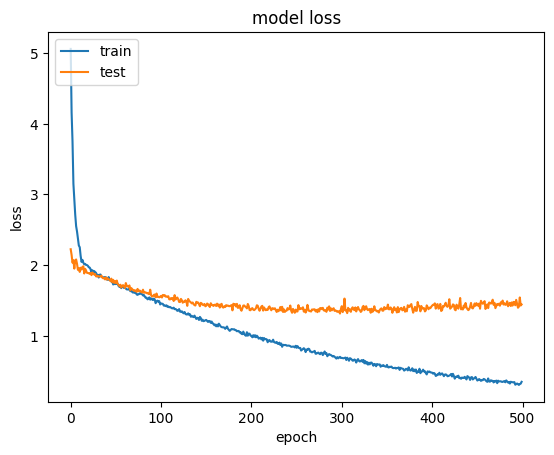

In [14]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('..//Pictures//Loss_Model.png') 
plt.show()

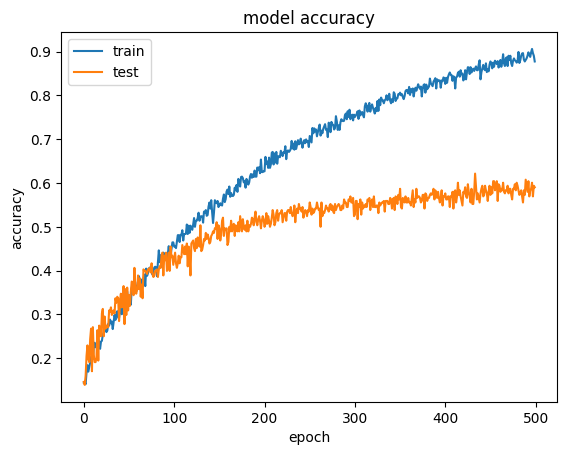

In [15]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('..//Pictures//Accuracy_Model.png') 
plt.show()

In [16]:
#loss and accuracy in testing dataset
loss,acc = model.evaluate(mfcc_test, emotions_test)
print("The accuracy of trained model is :{:5.2f}%".format(100*acc))

9/9 [==============================] - 0s 3ms/step - loss: 1.4442 - accuracy: 0.5903
The accuracy of trained model is :59.03%


In [17]:
# predictions = model.predict_classes(mfcc_test,axis=1)
predictions = np.argmax(model.predict(mfcc_test), axis=1)

In [18]:
#print(predictions)

## Confusion Matrix

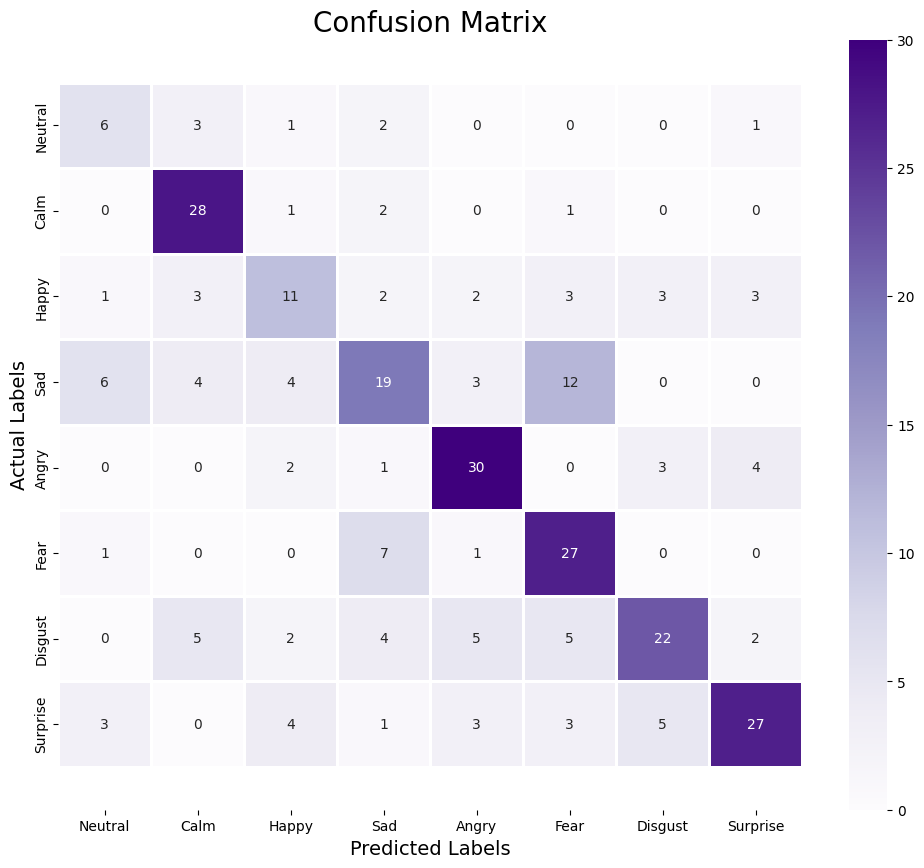

In [19]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

new_Ytest = emotions_test.astype(int)
matrix = confusion_matrix(new_Ytest, predictions)
# print (matrix)
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

plt.figure(figsize = (12, 10))
matrix = pd.DataFrame(matrix , index = ["Neutral","Calm","Happy","Sad","Angry","Fear","Disgust","Surprise"] , columns = ["Neutral","Calm","Happy","Sad","Angry","Fear","Disgust","Surprise"])
ax = sns.heatmap(matrix, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
# plt.savefig('..//Pictures//Confusion_matrix.png') 
plt.show()

### Printing Precision, Recall, F1-Score and Support values of model

In [20]:
from sklearn.metrics import classification_report

report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.35      0.46      0.40        13
           1       0.65      0.88      0.75        32
           2       0.44      0.39      0.42        28
           3       0.50      0.40      0.44        48
           4       0.68      0.75      0.71        40
           5       0.53      0.75      0.62        36
           6       0.67      0.49      0.56        45
           7       0.73      0.59      0.65        46

    accuracy                           0.59       288
   macro avg       0.57      0.59      0.57       288
weighted avg       0.60      0.59      0.58       288



In [21]:
#Saving our trained model
model_name = 'github_Ls2lax.h5'

model.save(model_name)
print("MODEL SAVED")

MODEL SAVED


In [24]:
#Loading back the saved model

our_model=tf.keras.models.load_model(model_name)


In [25]:
loss, acc = our_model.evaluate(mfcc_test, emotions_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

9/9 [==============================] - 0s 5ms/step - loss: 1.4442 - accuracy: 0.5903
Restored model, accuracy: 59.03%
